# Simple binary classification (Sonar, Mines vs. Rocks)

In this notebook we will fit the ML algorithms: Linear Regression, Logistic Regression, SVM, kNN and Decision trees, to a dataset containing stone and mine signals obtained from a variety of different aspect angles, with the aim of predicting whether an object is either a mine or a rock given the strength of sonar returns at different angles.

Let's read the data. The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine, we will asign the boolean 0 for the class "R", and the boolean 1 for the class "M" .

In [1]:
using CSV
using DataFrames

data = DataFrame(CSV.File("data/sonar.csv", header = 0) )
rename!(data, :Column61 => :class)
data.class = Bool.(replace(data.class, "R" => 0, "M" => 1));

Let's check if the classes are balanced.

In [2]:
using StatsBase
countmap(data.class)

Dict{Bool, Int64} with 2 entries:
  0 => 97
  1 => 111

As we can see, we have a problem of imbalanced classes. Since we don’t have a ton of data to work with, the Random Over-Sampling Technique can be a good choice to solve the problem.

In [3]:
using MLDataPattern

X = Matrix(data[:, 1:60])';
y = data.class;
X_bal, y_bal = oversample((X, y));


data_bal = DataFrame(Matrix(X_bal'));
data_bal.class = y_bal;

countmap(data_bal.class)

Dict{Bool, Int64} with 2 entries:
  0 => 111
  1 => 111

We would rather partition the balanced data set into three disjoint subsets (train, validation and test) using random assignment. We can do this by combining 'splitobs()' with 'shuffleobs()'.

In [4]:
using MLDataUtils 

class_0 = data_bal[data_bal[:, 61] .== 0, :]
class_1 = data_bal[data_bal[:, 61] .== 1, :]

train_class_0, validation_test_class_0 = splitobs(shuffleobs(class_0), at = 0.6)
validation_class_0, test_class_0 =  splitobs(shuffleobs(validation_test_class_0), at = 0.5)

train_class_1, validation_test_class_1 = splitobs(shuffleobs(class_1), at = 0.6)
validation_class_1, test_class_1 =  splitobs(shuffleobs(validation_test_class_1), at = 0.5)

train = shuffleobs(vcat(train_class_0 , train_class_1))
validation = shuffleobs(vcat(validation_class_0 , validation_class_1)) 
test = shuffleobs(vcat(test_class_0, test_class_1));

Now, our data train has 134 elements (60% of total data), the data validation has 44 elements (20% of total data), and the data train has 44 elements (20% of total data). In addition, its classes are distributed as follows

In [5]:
countmap(train.class)

Dict{Bool, Int64} with 2 entries:
  0 => 67
  1 => 67

In [6]:
countmap(validation.class)

Dict{Bool, Int64} with 2 entries:
  0 => 22
  1 => 22

In [7]:
countmap(test.class)

Dict{Bool, Int64} with 2 entries:
  0 => 22
  1 => 22

### Confusion Matrix

We will use the Confusion Matrix as a performance function for the problem. The Confusion matrix is a table with two rows and two columns that reports the number of true positives, false negatives, false positives, and true negatives, and is often used to evaluate the performance of a classification model. 

Different metrics are derived from this matrix, some of them are precision, accuracy, sensitivity and specificity. The convenience of using a metric as a measure of the estimator depends on each particular case and, specifically, on the "cost" associated with each classification error of the algorithm.

In [8]:
using EvalMetrics

function conf_matrix_metrics(test, pred)
    conf_matrix = counts(test, pred)
    precision = EvalMetrics.precision(test, pred)
    accuracy = EvalMetrics.accuracy(test, pred)
    sensitivity = EvalMetrics.sensitivity(test, pred)
    specificity = EvalMetrics.specificity(test, pred)
    
    println("The Confusion Matrix of this model is ", conf_matrix)
    println("The precision of this model is ", precision)
    println("The accuracy of this model is ", accuracy)
    println("The sensitivity of this model is ", sensitivity)
    println("The specificity of this model is ", specificity)
end

conf_matrix_metrics (generic function with 1 method)

In this classification problem, a true negative does not represent any risk for a person, while a false negative implies the possible loss of a person's life or the loss of some part of their body, we must avoid this situation. Therefore, the model to choose must have a high sensitivity, instead of a high specificity. This is the situation that interests us when our goal is to avoid false negatives at all costs.

## Linear Regression
Let's train Linear Regression model.

In [9]:
using GLM
fm = Term(:class) ~ sum(term.(names(train[:,1:60])))
linearRegressor = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

class ~ 1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)     Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)   -0.0565065    0.345038  -0.16    0.8704   -0.744167     0.631154
x1             2.73631      2.87867    0.95    0.3450   -3.00086      8.47349
x2             3.01936      2.54571    1.19    0.

Take a look at the decision values.

In [10]:
LinR_pred = Float64.(GLM.predict(linearRegressor,test))
println(LinR_pred)

[-0.49365558673917903, 0.17724498682047035, -0.12495776238031736, 0.8741171995769794, -0.3349626953013188, 0.7800252540423285, 0.7948313114863365, 0.25728924449589496, -0.4332621688358214, 1.3688350664322337, 0.5989410413355484, 0.4155976391794892, 0.6485990668194299, 0.25704542065017333, 1.1580044760100703, 1.9673556187098769, 0.8950603272330538, 0.5238855806148814, -0.03537615432315256, 0.5079919296727461, 0.35077963306858734, -0.14588480357323128, 2.4678793188411148, 1.2670293027559423, 0.21466593307644222, 0.19696968372507134, 0.8021999814940411, 0.8147275737491486, 0.9666647694033262, 0.49218898965610003, 1.2007958873562632, -0.4092228582159492, 0.5120647957296958, 0.42271503804293514, 0.4547214166272983, 0.7566179206120394, 0.05833076518450382, 0.3155612632047185, 0.28355142912015574, 0.31793678033630834, 0.3282995427494503, 0.30531641600145704, 1.5704180268193708, 0.36204602603210856]


### Prediction

Convert the decision values to a class.

In [11]:
y_test = Bool.(test.class)
y_LinR_pred = Bool.([if x < 0.5 0 else 1 end for x in LinR_pred]);

println("label_act  = ", y_test)
println("label_pred = ", y_LinR_pred)

label_act  = Bool[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
label_pred = Bool[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [12]:
conf_matrix_metrics(y_test, y_LinR_pred)

The Confusion Matrix of this model is [15 7; 9 13]
The precision of this model is 0.65
The accuracy of this model is 0.6363636363636364
The sensitivity of this model is 0.5909090909090909
The specificity of this model is 0.6818181818181818


## Logistic Regression
Let's train Logistic Regression model.

In [13]:
using GLM
fm = Term(:class) ~ sum(term.(names(train[:,1:60])))
logitRegressor = glm(fm, train, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

class ~ 1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x20 + x21 + x22 + x23 + x24 + x25 + x26 + x27 + x28 + x29 + x30 + x31 + x32 + x33 + x34 + x35 + x36 + x37 + x38 + x39 + x40 + x41 + x42 + x43 + x44 + x45 + x46 + x47 + x48 + x49 + x50 + x51 + x52 + x53 + x54 + x55 + x56 + x57 + x58 + x59 + x60

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                   Coef.      Std. Error      z  Pr(>|z|)        Lower 95%       Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)     6.53298    12104.0         0.00    0.9996   -23716.9         23729.9
x1            300.008          1.54047e5   0.00    0

Take a look at the decision values.

In [14]:
LogR_pred = Float64.(GLM.predict(logitRegressor,test))
println(LogR_pred)

[0.0, 0.9666602034013866, 1.0989663248103508e-112, 1.0, 2.545873788058098e-108, 1.0, 1.0, 5.721847755969251e-10, 0.437594897213171, 0.9999999999999367, 0.9999999999999999, 5.900182200663626e-16, 1.0, 0.9999519064072125, 1.0, 1.0, 1.0, 1.3467873917826363e-212, 1.0653746367360256e-15, 0.9608375805386096, 0.9996635570361933, 8.74766379285437e-120, 1.0, 1.0, 3.372151748505251e-9, 0.9999999999999993, 0.9999999999983946, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.2546858537266491, 4.711877751033098e-30, 1.0, 1.2663408452354713e-32, 0.060786403057826, 3.2826463132847187e-230, 0.999854222332258, 0.0008580080954947706, 1.3483764889796146e-15, 1.0, 3.6327881740915735e-185]


### Prediction

Convert probability score to a class.

In [15]:
y_test = Bool.(test.class)
y_LogR_pred = Bool.([if x < 0.5 0 else 1 end for x in LogR_pred]);

println("label_act  = ", y_test)
println("label_pred = ", y_LogR_pred)

label_act  = Bool[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
label_pred = Bool[0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [16]:
conf_matrix_metrics(y_test, y_LogR_pred)

The Confusion Matrix of this model is [13 9; 6 16]
The precision of this model is 0.64
The accuracy of this model is 0.6590909090909091
The sensitivity of this model is 0.7272727272727273
The specificity of this model is 0.5909090909090909


# Support Vector Machine (SVM)
Let's train SVM model with different kernels and varying their respectives hyperparameters.

## Polynomial kernel

We will train our model using the train set varying the hyperparameters $degree$ and $coef0$  from  $1$  to  $50$ and from $-1$ to $1$, respectivly. Then we will select the model with the best recall using the validation set.

In [17]:
X_train = Matrix(train[:, 1:60])'
X_val = Matrix(validation[:, 1:60])'

y_train = Bool.(train.class)
y_val = Bool.(validation.class);

In [18]:
using LIBSVM

recalls_SVM_Polynomial = []
for i in range(1, stop=50), j in range(-1, 1, length=101)
    model = svmtrain(X_train, y_train, kernel= Kernel.Polynomial, degree = i, coef0 = j)
    y_SVM_pred, _ = svmpredict(model, X_val)
    push!(recalls_SVM_Polynomial, [i,j,EvalMetrics.sensitivity(y_val, y_SVM_pred)])
end

using DataFrames
recalls_SVM_Polynomial = DataFrame(reduce(vcat,transpose.(recalls_SVM_Polynomial)));

In the next plot, we can see the recall for the hyperparameters $1 \leq degree \leq 50$ and $-1 \leq coef0 \leq 1$.

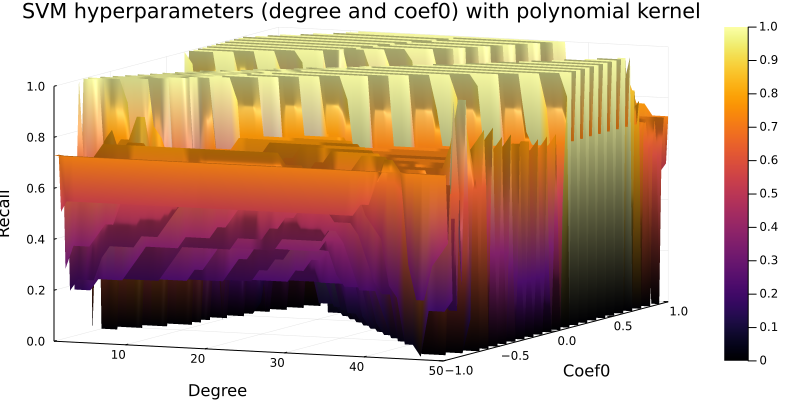

In [19]:
using Plots

surface(range(1, stop=50),
        range(-1, 1, length=101), 
        recalls_SVM_Polynomial[:,3],
     title = "SVM hyperparameters (degree and coef0) with polynomial kernel",
     xlabel = "Degree",
     ylabel = "Coef0",
     zlabel = "Recall")
plot!(size=(800,400))

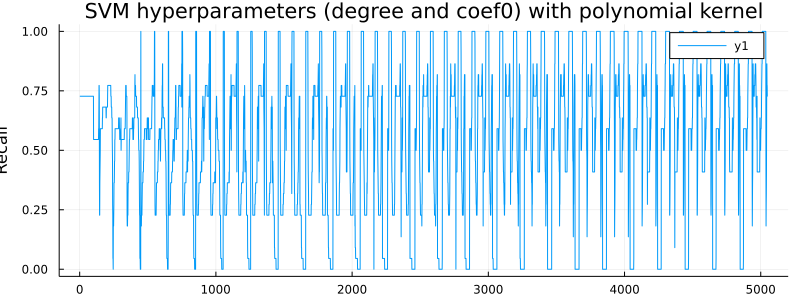

In [20]:
using Plots

plot(range(1, size(recalls_SVM_Polynomial)[1]),
     recalls_SVM_Polynomial[:,3],
     title = "SVM hyperparameters (degree and coef0) with polynomial kernel",
     ylabel = "Recall")
plot!(size=(800,300))

In [21]:
best_ij_Pol = Vector(sort(recalls_SVM_Polynomial, :x3, rev = true)[1,:])
println("The best hyperparameters of SVM with polynomial kernel are: degree -> ", best_ij_Pol[1], " and coef0 -> ", best_ij_Pol[2]," with a recall of ", best_ij_Pol[3])

The best hyperparameters of SVM with polynomial kernel are: degree -> 5.0 and coef0 -> -0.12 with a recall of 1.0


Now, we will retrain the model with the best hyperparameters that we just find.

In [22]:
train_val = vcat(train, validation)

X_train_val = Matrix(train_val[:, 1:60])'
X_test = Matrix(test[:, 1:60])'

y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class);

In [23]:
using LIBSVM

model = svmtrain(X_train_val, y_train_val, degree = Int(best_ij_Pol[1]), coef0 = best_ij_Pol[2], kernel = Kernel.Polynomial)
y_SVM_pred_Polynomial, _ = svmpredict(model, X_test);

Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [24]:
conf_matrix_metrics(y_test, y_SVM_pred_Polynomial)

The Confusion Matrix of this model is [4 18; 0 22]
The precision of this model is 0.55
The accuracy of this model is 0.5909090909090909
The sensitivity of this model is 1.0
The specificity of this model is 0.18181818181818182


## Sigmoid kernel

We will train our model using the train set varying the hyperparameter $coef0$ from $-6$ to $6$, then we will select the model with the best recall using the validation set.

In [25]:
X_train = Matrix(train[:, 1:60])'
X_val = Matrix(validation[:, 1:60])'

y_train = Bool.(train.class)
y_val = Bool.(validation.class);

In [26]:
using LIBSVM

recalls_SVM_Sigmoid = []
for i in range(-6,6, length=100)
    model = svmtrain(X_train, y_train, coef0 = i, kernel = Kernel.Sigmoid)
    y_SVM_pred, SVM_pred = svmpredict(model, X_val)
    push!(recalls_SVM_Sigmoid, [i,EvalMetrics.sensitivity(y_val, y_SVM_pred)])
end

using DataFrames
recalls_SVM_Sigmoid = DataFrame(reduce(vcat,transpose.(recalls_SVM_Sigmoid)));

In the next plot, we can see the recall for each hyperparameter $-6 \leq coef0 \leq 6$.

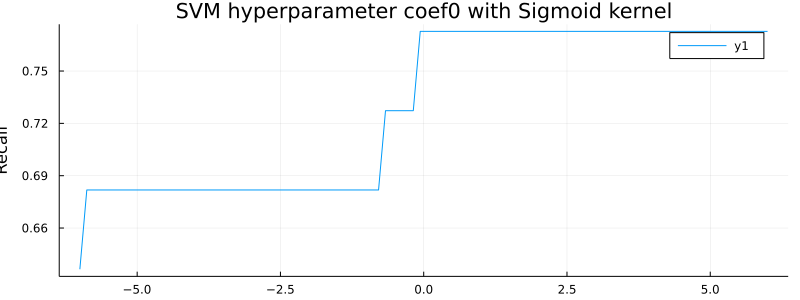

In [27]:
using Plots

plot(range(-6, 6, length=100),
     recalls_SVM_Sigmoid[:,2],
     title = "SVM hyperparameter coef0 with Sigmoid kernel",
     ylabel = "Recall")
plot!(size=(800,300))

In [28]:
best_coef_Sigmoid = Vector(sort(recalls_SVM_Sigmoid, :x2, rev = true)[1,:])
println("The best hyperparameter of SVM with polynomial kernel is: coef0 -> ", best_coef_Sigmoid[1], " with a recall of ", best_coef_Sigmoid[2])

The best hyperparameter of SVM with polynomial kernel is: coef0 -> -0.06060606060606061 with a recall of 0.7727272727272727


Now, we will retrain the model with the best hyperparameters that we just find.

In [29]:
train_val = vcat(train, validation)

X_train_val = Matrix(train_val[:, 1:60])'
X_test = Matrix(test[:, 1:60])'

y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class);

In [30]:
using LIBSVM

model = svmtrain(X_train_val, y_train_val, coef0 = best_coef_Sigmoid[1], kernel = Kernel.Sigmoid)
y_SVM_pred_Sigmoid, _ = svmpredict(model, X_test);

Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [31]:
conf_matrix_metrics(y_test, y_SVM_pred_Sigmoid)

The Confusion Matrix of this model is [10 12; 3 19]
The precision of this model is 0.6129032258064516
The accuracy of this model is 0.6590909090909091
The sensitivity of this model is 0.8636363636363636
The specificity of this model is 0.45454545454545453


## Linear kernel

In [32]:
train_val = vcat(train, validation)

X_train_val = Matrix(train_val[:, 1:60])'
X_test = Matrix(test[:, 1:60])'

y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class);

In [33]:
using LIBSVM

model = svmtrain(X_train_val, y_train_val, kernel = Kernel.Linear)
y_SVM_pred_Linear, _ = svmpredict(model, X_test);

Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [34]:
conf_matrix_metrics(y_test, y_SVM_pred_Linear)

The Confusion Matrix of this model is [15 7; 2 20]
The precision of this model is 0.7407407407407407
The accuracy of this model is 0.7954545454545454
The sensitivity of this model is 0.9090909090909091
The specificity of this model is 0.6818181818181818


## RadialBasis kernel

In [35]:
train_val = vcat(train, validation)

X_train_val = Matrix(train_val[:, 1:60])'
X_test = Matrix(test[:, 1:60])'

y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class);

In [36]:
using LIBSVM

model = svmtrain(X_train_val, y_train_val, kernel = Kernel.RadialBasis)
y_SVM_pred_RadialBasis, _ = svmpredict(model, X_test);

Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [37]:
conf_matrix_metrics(y_test, y_SVM_pred_RadialBasis)

The Confusion Matrix of this model is [9 13; 4 18]
The precision of this model is 0.5806451612903226
The accuracy of this model is 0.6136363636363636
The sensitivity of this model is 0.8181818181818182
The specificity of this model is 0.4090909090909091


# k Nearest Neighbors
Let's train k Nearest Neighbors model. First, we will train our model using the train set varying the hyperparameter $k$ from $1$ to $20$, then we will select the model with the best recall using the validation set.

In [38]:
using NearestNeighbors
X_train = Matrix(train[:, 1:60])'
X_valid = Matrix(validation[:, 1:60])'
X_test = Matrix(test[:, 1:60])'

y_train = Bool.(train.class)
y_valid = Bool.(validation.class)
y_test = Bool.(test.class)

recalls_kNN = []

for k in range(1, 20)
    kdtree_train = KDTree(X_train)
    idxs, dists = knn(kdtree_train, X_valid, k, true)
    nbors_labels = y_train[hcat(idxs...)']
    y_kNN_pred = [argmax(countmap(nbors_labels[i, :]))  for i in 1:size(nbors_labels)[1]]
    push!(recalls_kNN, EvalMetrics.sensitivity(y_valid, y_kNN_pred)) 
end

In the next plot, we can see the recall for each hyperparameter $1 \leq k \leq 20$ with $k \in \mathbb{N}.$

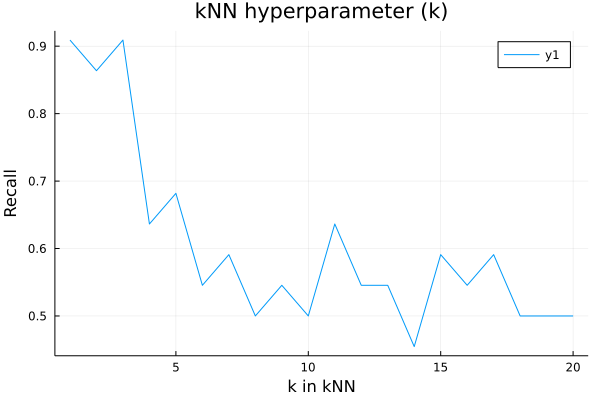

In [39]:
using Plots

plot(range(1, 20),
     recalls_kNN,
     title = "kNN hyperparameter (k)",
     ylabel = "Recall",
     xlabel = "k in kNN")

In [40]:
best_k = minimum(findall(x -> x == maximum(recalls_kNN), recalls_kNN));
println("The best kNN hyperparameter k is ", best_k )

The best kNN hyperparameter k is 1


Now, we will retrain the model with the best hyperparameter that we just find.

In [41]:
using NearestNeighbors

train_val = vcat(train, validation)
X_train_val = Matrix(train_val[:, 1:60])'
X_test = Matrix(test[:, 1:60])'
y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class)

k = best_k

kdtree_train = KDTree(X_train_val)
idxs, dists = knn(kdtree_train, X_test, k, true);

Take a look at the decision values.

In [42]:
nbors_labels = y_train_val[hcat(idxs...)'];
nbors_labels'

1×44 adjoint(::BitMatrix) with eltype Bool:
 0  1  0  1  0  1  1  1  1  0  0  0  1  …  0  0  1  0  0  0  0  1  1  0  0  0

### Prediction

Convert the decision values to a class.

In [43]:
y_kNN_pred = [argmax(countmap(nbors_labels[i, :]))  for i in 1:size(nbors_labels)[1]];
println("label_act  = ", y_test)
println("label_pred = ", y_kNN_pred)

label_act  = Bool[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
label_pred = Bool[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [44]:
conf_matrix_metrics(y_test, y_kNN_pred)

The Confusion Matrix of this model is [18 4; 3 19]
The precision of this model is 0.8260869565217391
The accuracy of this model is 0.8409090909090909
The sensitivity of this model is 0.8636363636363636
The specificity of this model is 0.8181818181818182


#  Decision trees
Let's train decision trees model, we will train our model using the train set varying the hyperparameter $max\text{_}depth$ from $1$ to $20$, then we will select the model with the best recall using the validation set.

In [45]:
using DecisionTree

X_train = Matrix(train[:, 1:60])
X_valid = Matrix(validation)[:, 1:60]
X_test = Matrix(test[:, 1:60])'

y_train = Bool.(train.class)
y_valid = Bool.(validation.class)
y_test = Bool.(test.class);

In [46]:
recalls_DT = []
for k in range(1, 20)
    model = DecisionTreeClassifier(max_depth=k)
    DecisionTree.fit!(model, X_train, y_train)
    y_DT_pred = DecisionTree.predict(model, X_valid)
    push!(recalls_DT, EvalMetrics.sensitivity(y_valid, y_DT_pred)) 
end

In the next plot, we can see the recall for each hyperparameter $1 \leq k \leq 20$ with $k \in \mathbb{N}.$

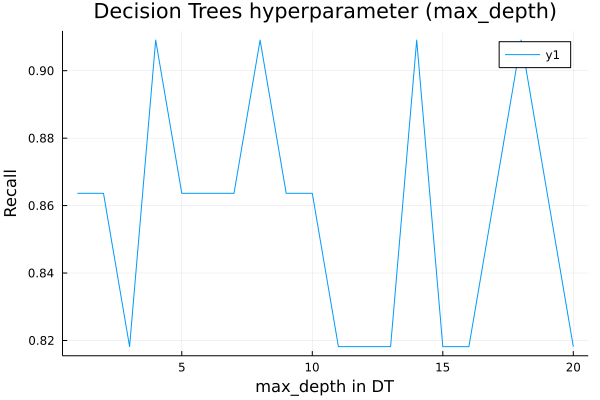

In [47]:
using Plots

plot(range(1, 20),
     recalls_DT,
     title = "Decision Trees hyperparameter (max_depth)",
     ylabel = "Recall",
     xlabel = "max_depth in DT")

In [48]:
best_k = minimum(findall(x -> x == maximum(recalls_DT), recalls_DT));
println("The best Decision Trees hyperparameter max_depth is ", best_k)

The best Decision Trees hyperparameter max_depth is 4


Now, we will retrain the model with the best hyperparameter that we just find.

In [49]:
using DecisionTree

train_val = vcat(train, validation)
X_train_val = Matrix(train_val[:, 1:60])
X_test = Matrix(test)[:, 1:60]
y_train_val = Bool.(train_val.class)
y_test = Bool.(test.class)

k = best_k

model = DecisionTreeClassifier(max_depth=k)
DecisionTree.fit!(model, X_train_val, y_train_val);

Take a look at the decision values.

In [50]:
DT_pred = predict_proba(model, X_test);
DT_pred'

2×44 adjoint(::Matrix{Float64}) with eltype Float64:
 1.0  0.9  0.40625  0.0  1.0  0.40625  …  1.0  0.0  1.0  0.0  0.0  0.0  0.9
 0.0  0.1  0.59375  1.0  0.0  0.59375     0.0  1.0  0.0  1.0  1.0  1.0  0.1

### Prediction

Convert probability score to a class.

In [51]:
y_test = Bool.(test.class)
y_DT_pred = DecisionTree.predict(model, Matrix(test)[:, 1:60]);

println("label_act  = ", y_test)
println("label_pred = ", y_DT_pred)

label_act  = Bool[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
label_pred = Bool[0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]


Now let's look at the model's confusion matrix along with the previously mentioned metrics.

In [52]:
conf_matrix_metrics(y_test, y_DT_pred)

The Confusion Matrix of this model is [15 7; 6 16]
The precision of this model is 0.6956521739130435
The accuracy of this model is 0.7045454545454546
The sensitivity of this model is 0.7272727272727273
The specificity of this model is 0.6818181818181818


## Algorithm with the highest performance measure

Let's compare the recall of each model.

In [53]:
models = ["Linear Regression", "Logistic Regression",
            "SVM: Sigmoid Kernel", "SVM: Linear Kernel", "SVM: RadialBasis Kernel", "kNN", "Decision Tree"]
name_preds = [y_LinR_pred, y_LogR_pred, y_SVM_pred_Sigmoid,
        y_SVM_pred_Linear, y_SVM_pred_RadialBasis, y_kNN_pred, y_DT_pred]
y_test = Bool.(test.class)
n = size(models)[1]

preds = []
function metrics()
    for i in 1:n
        push!(preds,  EvalMetrics.sensitivity(y_test, name_preds[i])) 
        println("The Recall (Sensitivity) of the ", models[i], " model is ", EvalMetrics.sensitivity(y_test, name_preds[i]))
    end
end

metrics (generic function with 1 method)

In [54]:
metrics()

The Recall (Sensitivity) of the Linear Regression model is 0.5909090909090909
The Recall (Sensitivity) of the Logistic Regression model is 0.7272727272727273
The Recall (Sensitivity) of the SVM: Sigmoid Kernel model is 0.8636363636363636
The Recall (Sensitivity) of the SVM: Linear Kernel model is 0.9090909090909091
The Recall (Sensitivity) of the SVM: RadialBasis Kernel model is 0.8181818181818182
The Recall (Sensitivity) of the kNN model is 0.8636363636363636
The Recall (Sensitivity) of the Decision Tree model is 0.7272727272727273


In [55]:
pos = findall(x->x==maximum(preds), preds)
println("For this problem, the best model is ", models[pos][1] , " with a recall of ", maximum(preds))

For this problem, the best model is SVM: Linear Kernel with a recall of 0.9090909090909091
